<img align="right" width="240" height="240" src="img/HS_Mu__nchen_Logo.png"/>

<style>
p.small {
  line-height: 1;
}
</style>
<body>
    
<p class="small"> <b>Geoinformatics | Course Remote Sensing (1)</b><br> <small>Schmitt | Ulloa</small><br> <small>Summer Semester 2020</small><br></p>

<h1>Practice 5: Supervised classification</h1>

<h2>Overview</h2>

<p class="main"><b>Objectives:</b> Perform a supervised classification of your AOI, on a multiband Sentinel image or Rasterstack. Test different algorithms for this.</p>

<p><b>Data:</b> For this practice, use the following files: </p>

<p class="data"></p>
<ul>
    <li> Raster file: GeoTIFF Sentinel-2A Rasterstack (S2A_L2A_T32UPU_rstck_id1.tif, S2A_L2A_T32UPU_rstck_id2.tif or S2A_L2A_T32UPU_rstck_id3.tif, depending of the AOI you were assigned.)</li> 
    <li> Vector file: your training polygons in Shapefile format.</li>
</ul>

<p><b>Tasks:</b> load your rasterfile and your training data in Python and perform a supervised classification. Test different algorithms and different values for the parameters. Export the classification files and visualize them.</p> 

<h2>Procedure</h2>

<h3>A. Prepare the settings on your computer</h3>

<img align="center" src="img/img_p5_wf1.png" width="900"/>

1. The first thing you always have to do, is to define which libraries or packages you will need. You don't need to change anything here. However, if you don't run this cell, the code won't work.

In [1]:
# packages
import os 
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from matplotlib.colors import ListedColormap # to import certain defined color palettes for plotting your results
from sklearn.ensemble import RandomForestClassifier # classifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
from sklearn.neighbors import KNeighborsClassifier
from skimage import exposure # for adjustment of rasterstack (histogram equalization, etc)

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

2. Afterwards, you have to define the paths where your data is located. You can also specify where you want the results to be saved. Please adapt the following code, with the path of the files on your computer.   
Remember to add an "r" at the beginning of your path.

In [2]:
# path where my data is located
folder_src = r"C:\Users\ulloa-to\PythonProjects\practices_fe1_ss2020\scripts\data\p5"

# path where I want to save my results 
folder_results = r"C:\Users\ulloa-to\PythonProjects\practices_fe1_ss2020\scripts\data\p5\results"

3. Here I added some general setting commands. Run this command for better performance on your computer.

In [3]:
# how many cores should be used?
n_cores = -1
# -1 -> all available cores

<h3>B. Load your data in Python</h3>

<img align="center" src="img/img_p5_wf2.png" width="900"/>

4. Load the raster file that you want to classify. Adapt the code to your data.

In [4]:
# this command pastes the path to your file (defined by 'folder_src') and the name of your file
# since my raster is located in a subfolder 'raster', I include it as well 
s2_stack = os.path.join(folder_src,'raster/S2A_L2A_T32UPU_rstck_id2.tif')
s2_stack

'C:\\Users\\ulloa-to\\PythonProjects\\practices_fe1_ss2020\\scripts\\data\\p5\\raster/S2A_L2A_T32UPU_rstck_id2.tif'

5. Extract the information of your raster data. Here, you make the attributes readable for the classification algorithm. Afterwards, the data is being transformed into a Numpy array for easier calculations.  
Check the printing commands and the variables that are being used!

In [5]:
# load image data
#In this script we are Using gdal.open() instead of rio.open()
img_ds = gdal.Open(s2_stack, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

print("Raster format is:", gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
    
# store the variables above in a more meaningful way. You will use these variables later.
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print("Raster number of rows: {}".format(row))
print("Raster number of columns: {}".format(col))
print("Raster number of bands: {}".format(band_number))


Raster format is: <class 'numpy.float32'>
Raster number of rows: 186
Raster number of columns: 209
Raster number of bands: 4


In [6]:
img.shape

(186, 209, 4)

6. Reshape your raster to turn it into a Numpy Array for the classification. We do not need the location anymore, since we will be working with the distance among pixels in terms of the difference of reflectance among them.   

In [7]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

Reshaped from (186, 209, 4) to (38874, 4)


7. Load your training data (shapefiles). Define the column that has the attributes (i.e. 'landclass' OR 'class' OR 'landcover').   
Adapt the code to your data.

In [8]:
# this command pastes the path to your file (defined by 'folder_src') and the name of your file
# since my raster is located in a subfolder 'vector', I include it as well
training = os.path.join(folder_src,'vector/train.shp')
training

'C:\\Users\\ulloa-to\\PythonProjects\\practices_fe1_ss2020\\scripts\\data\\p5\\vector/train.shp'

In [9]:
# what is the numerical attribute of your classes in the shapefile?
attribute = 'id'

8. Extract the information of your training data. Here, you make the attributes readable for the classification algorithm.

In [10]:
# load training data and show all shapefile attributes
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = [] # empty list where the attributes will be saved
ldefn = shape_layer.GetLayerDefn() # encapsulates the attribute schema of the features of the layer
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shapefile are: {}'.format(attributes))

Available attributes in the shapefile are: ['id', 'class']


9. Rasterize your training polygons. This means, that your polygons won't be a shapefile anymore, but they will be turned into little rasters.

In [11]:
# copy the structure of your Sentinel2 image to pass this information to the new rasterized polygons
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute

# rasterize your polygons
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()

# for more info: 
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster

10. Voilà! Now you have your polygons in the same resolution and projection as your Sentinel-2 Rasterstack. The next task is to extract the training pixels (OR 'samples') from the Rasterstack.  
The samples will be used for training the classification algorithm. In total, I am extracting 435 samples from the matrix 'X', using the array 'y'.

In [12]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


435 training samples
training data include 6 classes: [1 2 3 4 5 6]
Our X matrix is sized: (435, 4)
Our y array is sized: (435,)


11. You can plot this data, to have an overview of what you have done so far. 

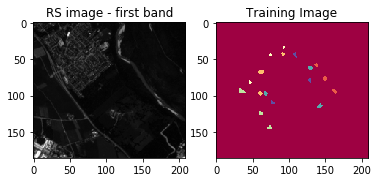

In [13]:
# Plot your raster
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

# Plot your training polygons
plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

12. In the last function, do you know what the numbers 121 or 122 mean?  
These numbers refer to : nrows, ncols, and index, in order.   
Try the previous code again and this time place one plot below the other.   
For more parameters, check: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot.html

13. Do you want to plot the training polygons on top of your raster? Use the same functions as before but get rid of the "plt.subplot()" command.  
For the shapefile use: "plt.imshow(roi, cmap='jet', alpha=0.5)".  
Keep also in mind that in this case it is enough with only one "plt.title('text')" command.

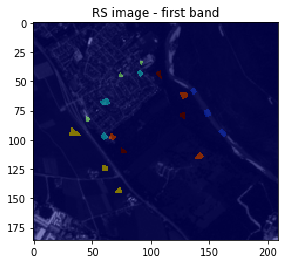

In [14]:
# Plot your raster
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')
plt.imshow(roi, cmap='jet', alpha=0.5)


plt.show()

<p>In this practice, you will load your raster + training polygons and apply different algorithms. We will start with Minimum Distance.</p>

<h3>B. Classification - MD</h3>


<img align="center" src="img/img_p5_wf3.png" width="900"/>

<h4>Minimum distance</h4>

<h5>The minimum distance classifier is used to classify unknown image data to classes which minimize the distance between the image data and the class in multi-feature space. The distance is defined as an index of similarity so that the minimum distance is identical to the maximum similarity.</h5>

<img align="center" src="img/img_p5_md.png" width="900"/>

<p><a href= "https://www.researchgate.net/publication/294596525_An_investigation_of_the_design_and_use_of_feed-forward_artificial_neural_networks_in_the_classification_of_remotely_sensed_images">Source image</a></p>

14. Perform a Minimum Distance classification. For this, you will use the function K-NearestNeighbors with K=1, from the scikit-learn package. In this function, you are using Euclidean Distance, which is the distance used in 'Minimum Distance'.    
In this step, you are training the algorith using your training data.  
More info: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [15]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=n_cores)
X = np.nan_to_num(X)
knnraster = knn.fit(X, y)

15. With the algorithm trained, now you can predict the rest of the pixels of your image.

In [16]:
# Predicting the rest of the image
# Use the raster in the format assigned on question nr.6
img_as_array = np.nan_to_num(img_as_array)
# THIS IS YOUR CLASSIFICATION OUTPUT
knn_prediction = knn.predict(img_as_array)

knn_prediction = knn_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(knn_prediction.shape))

Reshaped back to (186, 209)


16. Plot your results. In my training dataset, I have the following classes:  
 - water = 1  
 - urban residential = 2  
 - urban industrial = 3  
 - agricultural = 4  
 - broadleaved forest = 5  (Laubwald)  
 - coniferous forest = 6  (Nadelwald)  

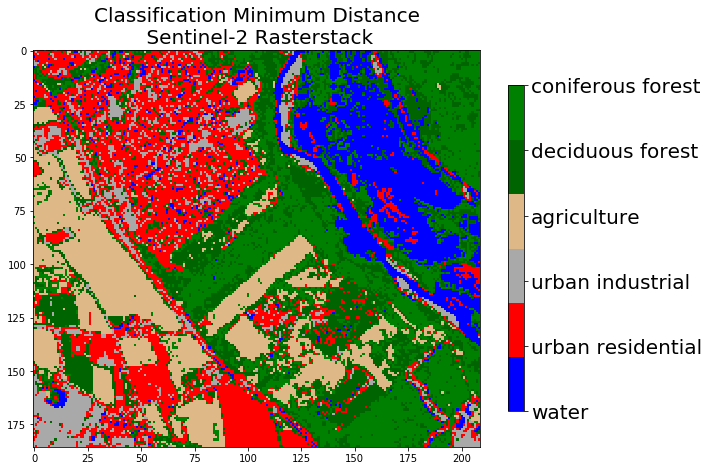

In [17]:
# assing colors to each class. The order of the colors depends on the order of the landclasses
custom_cmap = ListedColormap(["blue","red","darkgrey","burlywood", "darkgreen","green"])
# for example, here water = "lightseagreen"

# plot your classification
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('Classification Minimum Distance\n Sentinel-2 Rasterstack', fontsize = 20) # use '\n' to start a new line
plot_md =ax.imshow(knn_prediction, cmap=custom_cmap) # indicate which file will be plottd, add colors
# set parameters for colorbar
cbar_md = plt.colorbar(plot_md,shrink=0.6) 
cbar_md.set_ticks([1,2,3,4,5,6])
cbar_md.set_ticklabels(["water", "urban residential", "urban industrial", "agriculture", "deciduous forest", "coniferous forest"])
cbar_md.ax.tick_params(labelsize=20) # adapt font size of ticks
# show your plot
plt.show()

# More info on plotting functions: 
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html

17. How good is your classification? What can you do to improve it?

<img align="center" src="img/img_p5_wf4.png" width="900"/>

18. Export your results.

In [18]:
# define where the image will be saved
classification_image=os.path.join(folder_results,'md_classi.tif')

# define structure of your output file
driver = gdal.GetDriverByName("gtiff")
cols = img.shape[1]
rows = img.shape[0]
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input

# specify which image you want to save
outdata.GetRasterBand(1).WriteArray(knn_prediction)

#saves to disk!!
outdata.FlushCache() 

print('Image saved to: {}'.format(classification_image))

Image saved to: C:\Users\ulloa-to\PythonProjects\practices_fe1_ss2020\scripts\data\p5\results\md_classi.tif


<h3>C. Classification - RF</h3>

<img align="center" src="img/img_p5_wf3.png" width="900"/>

<h4>Random Forest</h4>
<h5>A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting</h5>

<img align="center" src="img/img_p5_rf.png" width="900"/>

<p><a href= "https://www.javatpoint.com/machine-learning-random-forest-algorithm">Source image</a></p>


19. Perform a Random Forest classification. (Basically, train the algorith using your training data)

In [19]:
# Check the number of samples we are using
X.shape[0] 

435

In [20]:
# define a number of trees that should be used (default = 100)
est = 250

# run the RF algorithm
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores, bootstrap = True)
X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.2s finished


20. With the algorithm trained, now you can predict the rest of the pixels of your image

In [26]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array)/2))
    
    
    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
                       
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = slices/2
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')
    
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (186, 209)


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.2s finished


21. Plot your results. In my training dataset, I have the following classes:  
 - water = 1  
 - urban residential = 2  
 - urban industrial = 3  
 - agricultural = 4  
 - broadleaved forest = 5  (Laubwald)  
 - coniferous forest = 6  (Nadelwald)  

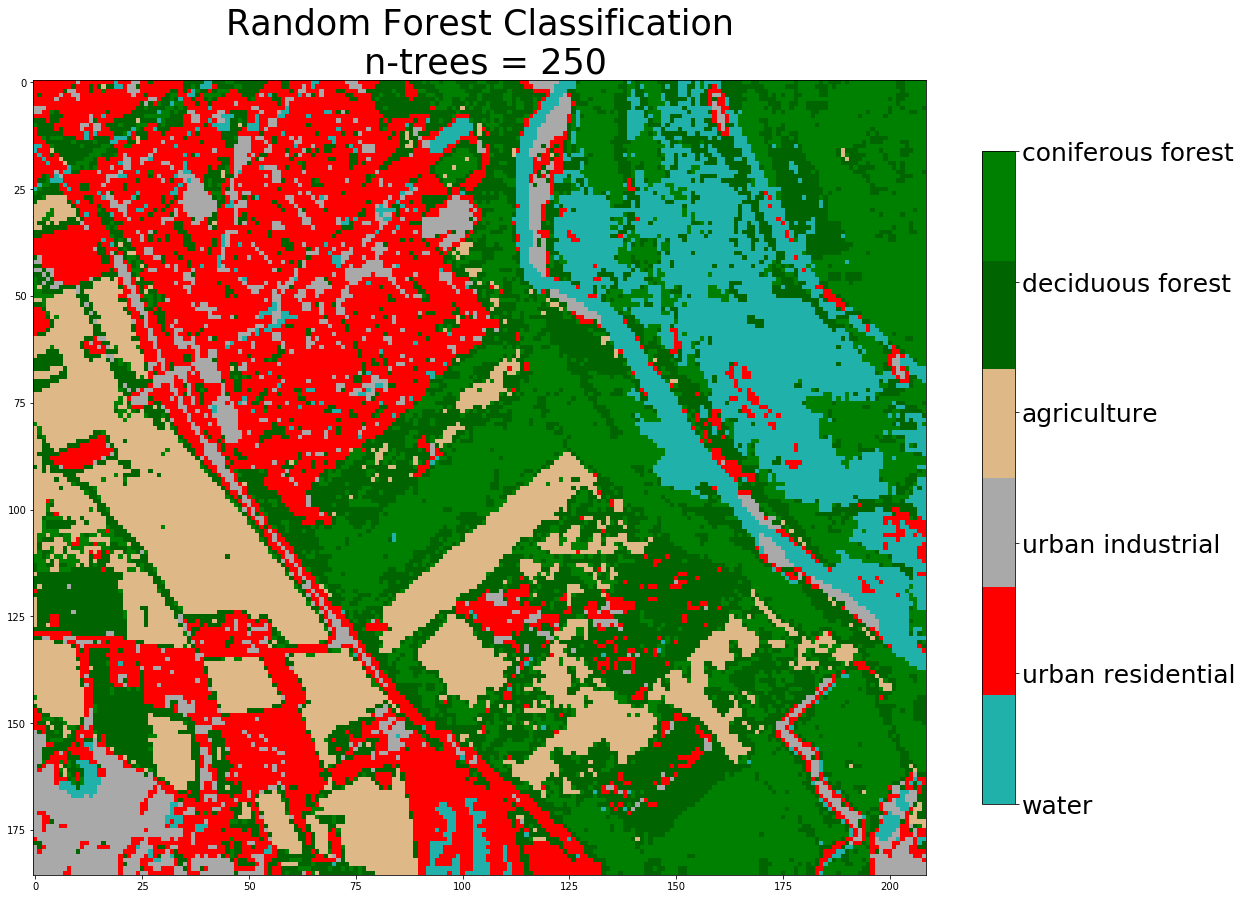

In [23]:
# assing colors to each class. The order of the colors depends on the order of the landclasses
custom_cmap = ListedColormap(["lightseagreen","red","darkgrey","burlywood", "darkgreen","green"])
# for example, here water = "lightseagreen"

# plot your classification
fig,ax = plt.subplots(figsize=(20,20))
ax.set_title('Random Forest Classification\n n-trees = 250', fontsize = 35) # use '\n' to start a new line
# indicate which file will be plotted, add colors
plot_rf =ax.imshow(class_prediction, cmap=custom_cmap) 
# set parameters for colorbar
cbar_rf = plt.colorbar(plot_rf,shrink=0.6) 
cbar_rf.set_ticks([1,2,3,4,5,6])
cbar_rf.set_ticklabels(["water", "urban residential", "urban industrial", "agriculture", "deciduous forest", "coniferous forest"])
cbar_rf.ax.tick_params(labelsize=25) # adapt font size of ticks
# show your plot
plt.show()

# More info on plotting functions: 
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html

22. How good is your classification? What can you do to improve it?

23. Run RF again, and compare the results with different values of:   
    * n_estimators (number of trees): 100, 500, 1000
    * bootstrap = False
    * max_samples = 50, 100, 500

What is the importance of these parameters?  
Check the parameters of this function here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<img align="center" src="img/img_p5_wf4.png" width="900"/>

24. Export your results (use the same block of functions as for KNN, adapt values)

In [24]:
# define where the image will be saved
classification_image=os.path.join(folder_results,'rf_nt250.tif')
cols = img.shape[1]
rows = img.shape[0]

# define structure of your output file
driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input

# specify which image you want to save
outdata.GetRasterBand(1).WriteArray(class_prediction)

#saves to disk!!
outdata.FlushCache() 

print('Image saved to: {}'.format(classification_image))

Image saved to: C:\Users\ulloa-to\PythonProjects\practices_fe1_ss2020\scripts\data\p5\results\rf_nt250.tif


<h3>D. Summary</h3>

25. Visualize all your interim and final results (Zwischen- und Endergebnisse)

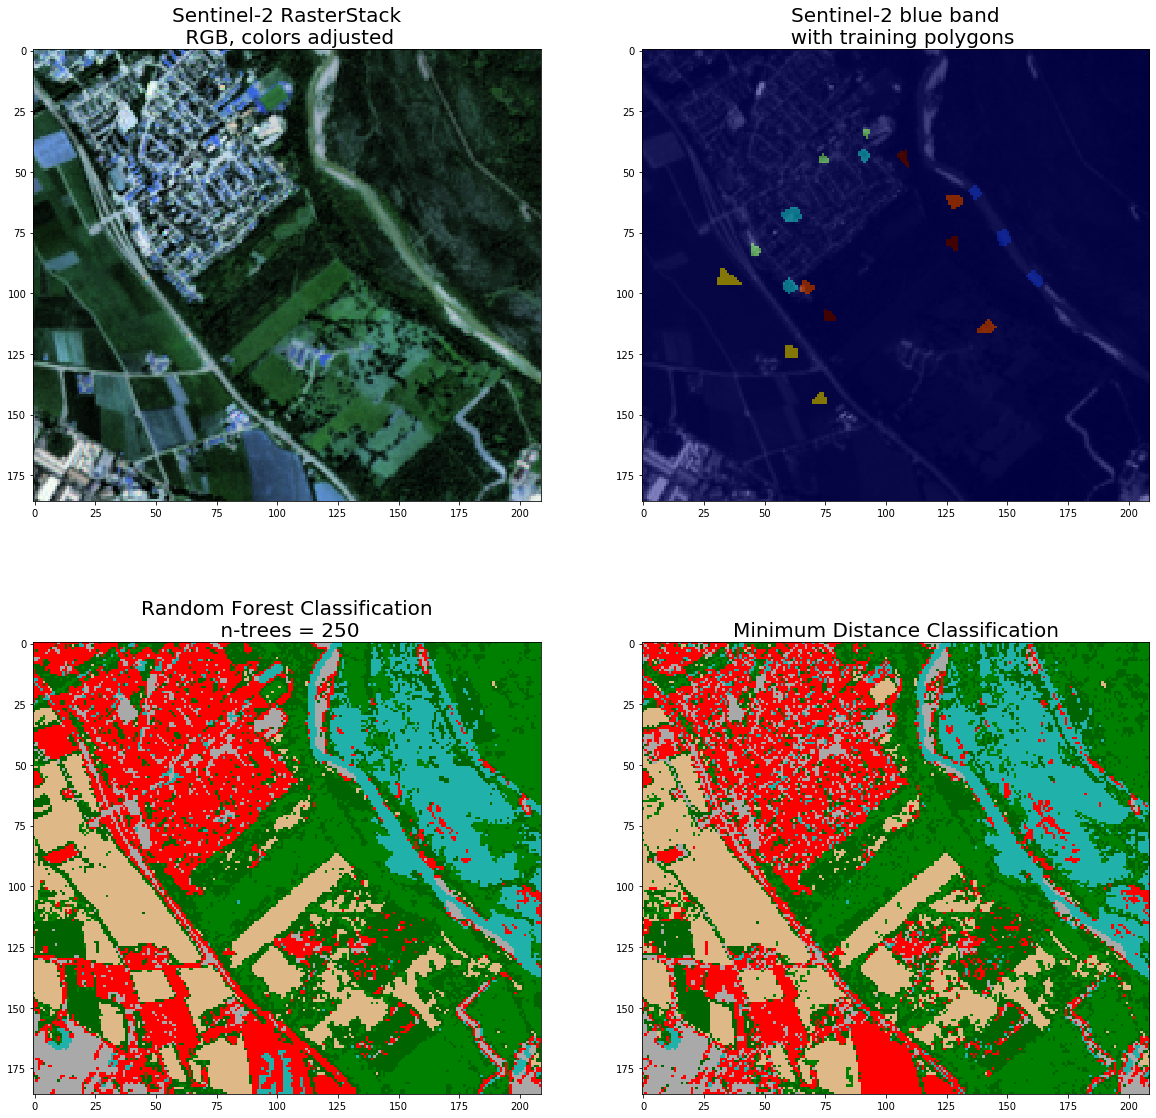

In [25]:
# Define the size of the graphs
plot=plt.subplots(figsize=(20,20))
# Define the spacing among graphs
fig.tight_layout(pad=4.0)

# Plot the rasterstack with an Adaptive Equalization
plt.subplot(221)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
plot_rs = plt.imshow(img_adapteq)
plt.title('Sentinel-2 RasterStack\n RGB, colors adjusted', fontsize=20)
## More info: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

# Plot the blue band with the training polygons
plt.subplot(222)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
# Add your training polygons on top
plot_tr = plt.imshow(roi, cmap='jet', alpha=0.5)
plt.title("Sentinel-2 blue band\n  with training polygons", fontsize=20)
                  
# Plot the RandomForest classification
plt.subplot(223)
plot_rf = plt.imshow(class_prediction, cmap=custom_cmap)
plt.title('Random Forest Classification\n n-trees = 250', fontsize=20)
## I eliminated here the colorbar, for visualization purposes

# Plot the Minimum Distance classification
plt.subplot(224)
plot_md = plt.imshow(knn_prediction, cmap=custom_cmap)
plt.title('Minimum Distance Classification', fontsize=20)
## I eliminated here the colorbar, for visualization purposes

# show your plots. This command has to be run only once.
plt.show()



26. Can you summarize your results in the following terms?:  
   - Which algorithm provided better results? Why?   
   - What is it necessary to improve classification results? (think about the parameters you have used: number of landclasses, number of samples, number training polygons, quality of the training polygons made, number of trees [RF], type of classification)

<div style="text-align: right"> <small>This tutorial was prepared with the support from Gabriel Cevallos. May 2020</small> </div>